# TSP Lecture - HA Models

Jamie Lenney 

Dec 2025 


## Objectives

* Motivate incomplete markets 

* Understand how income risk and borrowing constraints underpin HA model mechanisms

* Know how to solve a HA

* Examine the properties of a Hugget model

**Further reading** - Ljungqvist and Sargent Recursive Macroeconmic Theroy chapters: 17,18 

%jupyter nbconvert notebook.ipynb --to slides --SlidesExporter.reveal_theme=sky


## Incomplete Markets 

What is this? 

* Can think of a representative agent model as a model where individuals have written contracts to hedge against all risk
    * They are still exposed to aggregate risk
    * Can still have complete markets models with wealth distribution but all agents consumption would move proportinally in the same way. 

* When this is not possible we have incomplete markets
    * e.g. There are not sufficient assets/contracts to trade. 

* Incomplete markets creates incentives for self-insurance
    * Saving for a 'rainy day'




## Consumption Savings Problem

In [54]:
cali={} # calibration

# household 
cali['beta']=0.98 # patience
cali['sigma']=2 # risk aversion
cali['eis']=1/cali['sigma'] # intertemporal elasticity of substitution
cali['bc']=-0.2
cali['borwedge']=0.0

cali['rho_z']=0.97
cali['sd_z']=0.6

# aggregate economy
cali['r']=0.04/4
cali['w']=1.0
cali['govT']=0

# discretization
cali['nA']=200
cali['nZ']=5
cali['amax']=100


In [55]:
import numpy as np
from sequence_jacobian import het, interpolate, misc, grids,utilities

## Household problem

def make_grid(bc, amax, nA,nZ,rho_z,sd_z):
    
    z_grid, pi_z, Pi = grids.markov_rouwenhorst(rho=rho_z, sigma=sd_z, N=nZ)  
    a_grid = utilities.discretize.nonlinspace(amax,nA ,1.5, amin = bc) # normalized grid between zero and one with n_a number of points
    
    return z_grid, pi_z, Pi, a_grid


def income(w,r,borwedge,a_grid,z_grid,govT):

    rexpand=r*np.ones_like(a_grid) 
    rexpand[a_grid<0]=r+borwedge
    coh = (1+rexpand)*a_grid + w*z_grid[:, np.newaxis]+govT

    return coh


def household_init( r, coh, eis): # initial guess for marginal value function
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)
    return Va


In [56]:
@het(exogenous='Pi', policy='a', backward='Va', backward_init=household_init)
def household(Va_p, a_grid, r, coh, beta, eis,nZ):
    """Single backward iteration step using endogenous gridpoint method for households with CRRA utility.

    Parameters
    ----------
    Va_p     : array (nE, nA), expected marginal value of assets next period
    a_grid   : array (nA), asset grid
    z_grid   : array (nE), producticity grid
    r        : scalar, ex-post real interest rate
    w        : scalar, wage
    beta     : scalar, discount factor
    eis      : scalar, elasticity of intertemporal substitution

    Returns
    ----------
    Va : array (nE, nA), marginal value of assets today
    a  : array (nE, nA), asset policy today
    c  : array (nE, nA), consumption policy today
    """

    uc_nextgrid= beta * Va_p

    c_today = uc_nextgrid ** (-(eis))
    
    a = interpolate.interpolate_y(c_today + a_grid, coh, a_grid) # when i have coh(t)=c_today(t) + a_grid(t+1) i chose a_grid, what do i choose if on the coh grid today?
    misc.setmin(a, a_grid[0]) # apply borrowing constraint
    c = coh - a # work out consumptin policy today on the a_grid
    Va = (1 + r) * c ** (-1 / (eis)) #calculate marginal value today on the a_grid

    return Va, a, c

In [57]:
hh=household.add_hetinputs([make_grid,income])

ss0=hh.steady_state(cali)


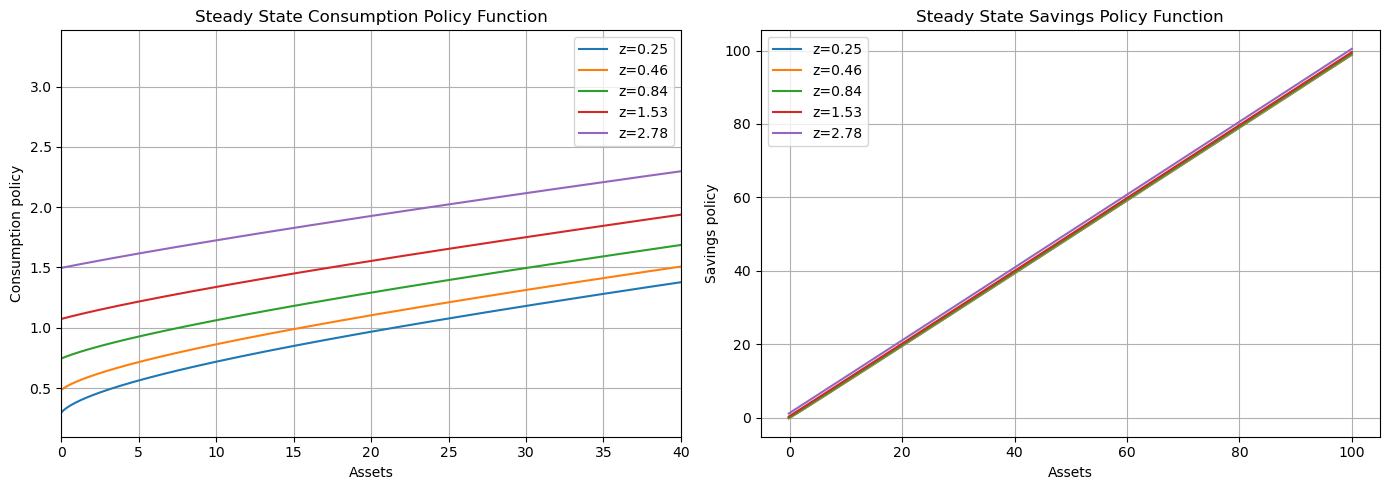

In [58]:

from matplotlib import pyplot as plt
a_grid=ss0.internals['household']['a_grid']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Consumption policy
ax1.plot(a_grid, ss0.internals['household']['c'][:,:].T)
ax1.set_xlabel('Assets')
ax1.set_ylabel('Consumption policy')
ax1.set_title('Steady State Consumption Policy Function')
ax1.legend(['z='+str(round(z,2)) for z in ss0.internals['household']['z_grid']])
ax1.grid()
ax1.set_xlim(0,40)

# Right panel: Savings policy
ax2.plot(a_grid, ss0.internals['household']['a'][:,:].T)
ax2.set_xlabel('Assets')
ax2.set_ylabel('Savings policy')
ax2.set_title('Steady State Savings Policy Function')
ax2.legend(['z='+str(round(z,2)) for z in ss0.internals['household']['z_grid']])
ax2.grid()

fig.tight_layout()


fig.savefig('steady_state_consumption_policy.png')

### Consumption Functions

![Economic Model](steady_state_consumption_policy.png)




### Aggregate Savings

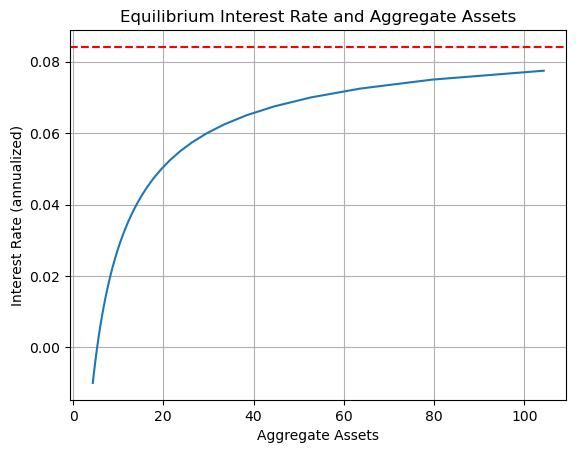

In [59]:
import copy 

r_grid=np.arange(-0.01,0.08,0.0025)/4
A_grid=np.zeros_like(r_grid)
ss_list=[]

cali_r=copy.deepcopy(cali)

for r in r_grid:
    cali_r['r']=r
    ss=hh.steady_state(cali_r)
    ss_list.append(ss)
    A_grid[np.where(r_grid==r)[0][0]]=ss['A']

plt.plot(A_grid,r_grid*4)
plt.ylabel('Interest Rate (annualized)')
plt.xlabel('Aggregate Assets')
plt.title('Equilibrium Interest Rate and Aggregate Assets')
plt.axhline(y=1/cali['beta']**4-1, color='r', linestyle='--', label='CM baseline')
plt.grid()

plt.savefig('equilibrium_interest_rate_vs_aggregate_assets.png')


![Aggregate Savings](equilibrium_interest_rate_vs_aggregate_assets.png)

